## Roughening of a FA front

Goal is to calculate the roughness exponent of a front in the Fredrickson-Andersen model in 2D. For simplicity, we use a flat, rather than droplet, initial condition, nucleating the first row with 1s.

We would like a procedure for cutting the system down to size as it grows. If we assume that the system approaches the steady state far behind the front, we can just do this by periodically resetting the height

### Multispin encoding

We'll use the trick of encoding 64 configurations by using 64 bit unsigned integers (`UInt`s). The update uses only bitwise operations, so allows us to run 64 simulations in parallel (we could do more on multiple cores)

### Finding the front

In the function `front_interior()` we use the nice trick of `accumulate` with an or function to find the boundary. This gives a front shape from which the mean and variance can be calculated. There is one subtlety. In the continuum, if we have the complementary cumulative distribution function $\bar F(x)$ for a random variable on $x\geq 0$, we can show that

$$
\mathbb{E}(x) = \int_0^\infty \bar F(x)dx
$$

$$
\mathbb{E}(x^2) = 2\int_0^\infty \bar xF(x)dx
$$

For distributions on the positive integers, there is a correction

$$
\mathbb{E}(x^2) = 2\sum_{x=1}^\infty x \bar F(x) - \mathbb{E}(x)
$$

I initially missed this out and then saw a sharp feature in the results when the resetting of the front started.

In [1]:
addprocs(8)

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [12]:
@everywhere using Images, Plots

In [3]:
@everywhere function KA_update(config)
        
    L, H = size(config)
    
    neighbours = .|(circshift(config, (0,1)), circshift(config, (0,-1)), 
        circshift(config, (1,0)), circshift(config, (-1,0)))
    
    # Prevent growth around the back...
    neighbours[:,end] = zeros(UInt64, L)
    
    # Flips up (1s) 3x more likely than flips down (0s)
    flips = .|(rand(UInt64, size(config)), rand(UInt64, size(config)))
    
    # Update is done by Fredkin gate using neighbours as control
    config .= xor.(config, xor.(flips, config) .& neighbours)
    
#     config .= xor.(flips .& neighbours, config)
        
    return config
end

The function below finds the distribution of the front (last 1) in the 64 realizations.

In [4]:
@everywhere function front_interior(config::Array{UInt,2})
    front = count_ones.(accumulate(|, config[:,end:-1:1], 2))
    return front[:,end:-1:1] / 64
end

Mean and variance of the front for a single spin configuration

In [5]:
@everywhere function front_mean_and_var(config::BitArray{2})
    
    L, H = size(config)
    
    front = H - squeeze(mapslices(x -> findmax(x)[2],config[:,end:-1:1],2),2)
    
    front_mean = sum(front) / L
    front_var = sum(front.^2) / L - front_mean^2
    
    return front_mean, front_var
end

Mean and variance of the front for a multispin configuration

In [6]:
@everywhere function front_mean_and_var(config::Array{UInt,2})
    
    L, H = size(config)
    
    front = front_interior(config)
    front_sum = squeeze(sum(front,1),1) / L
    front_mean = sum(front_sum)
    front_var = 2 * dot(front_sum, (1:H)) - front_mean^2 - front_mean
    
    return front_mean, front_var
end

Functions to prepare initial conditions for one configuration or using multispin encoding

In [7]:
@everywhere function init_config_onespin(L, H)
    config = falses(L, H)
    config[1:L] = trues(L)
    return config
end

In [8]:
@everywhere function init_config_multispin(L, H)
    config = zeros(UInt64, L, H)
    config[1:L] = parse(UInt64, "1"^64, 2)
    return config
end

Simulation runner function

In [9]:
@everywhere function runsim(T, init_config)
    
    L, H = size(init_config)
    
    config = init_config
    roughness = []
    
    for t in 1:T
        config = KA_update(config)
        
        if t%10 == 0
            front_mean, front_var = front_mean_and_var(config)
            append!(roughness, front_var)
            # if front gets too high we roll it back
            if front_mean > H / 2 + 5
                config = circshift(config, (0,-10))
                if config isa Array{UInt,2}
                    config[:,end-9:end] = zeros(UInt64, L, 10)
                elseif config isa BitArray{2}
                    config[:,end-9:end] = falses(L, 10)
                end
            end
        end
        if t % 10000 == 0
            println("Step: ", t)
        end
    end
    
    return roughness, config
end

## Sample results

This is what the front looks like in a single configuration

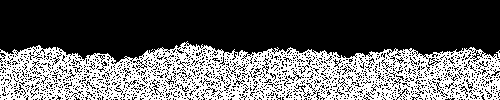

In [23]:
initial = init_config_onespin(500, 100)
roughness, final = runsim(1000,initial)
Gray.(transpose(final[:,end:-1:1]))

In [29]:
Images.save("front.png",Gray.(transpose(final[:,end:-1:1])))

For multispin configurations. The first one for $L=1000$

Step: 10000
Step: 20000
Step: 30000
Step: 40000
Step: 50000
Step: 60000
Step: 70000
Step: 80000
Step: 90000
Step: 100000


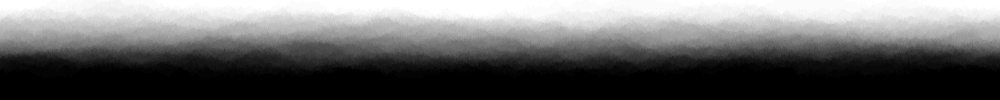

In [21]:
initial = init_config_multispin(1000, 100)
roughness1k, final1k = runsim(100000,initial)
final_front1k = front_interior(final1k);

Gray.(transpose(final_front1k))

The 64 realizations give rise to a smeared front (note this represents the distributon of the front)

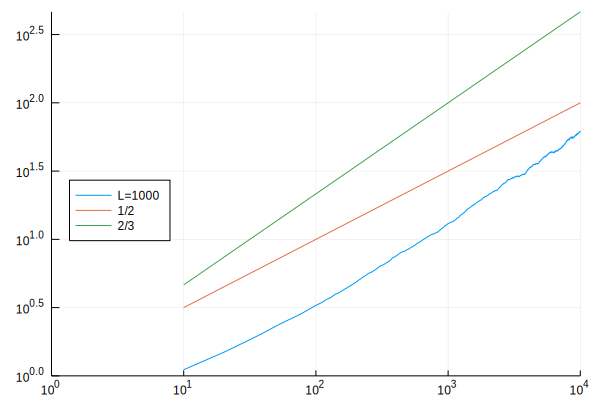

In [23]:
plot(10:10:10000, [roughness1k,collect(10:10:10000).^(1/2),collect(10:10:10000).^(2/3)], xaxis=(:log10, (1,Inf)), yaxis=(:log10, (1,Inf)),
legend=:left, label=["L=1000","1/2","2/3"])

Let's look at the effect of finite length for $T=10000$ for various lengths

In [13]:
initial = init_config_multispin(10000, 100)
roughness10000, final10000 = runsim(10000,initial);

In [14]:
initial = init_config_multispin(1000, 100)
roughness1000, final1000 = runsim(10000,initial);

In [15]:
initial = init_config_multispin(100, 100)
roughness100, final100 = runsim(10000,initial);

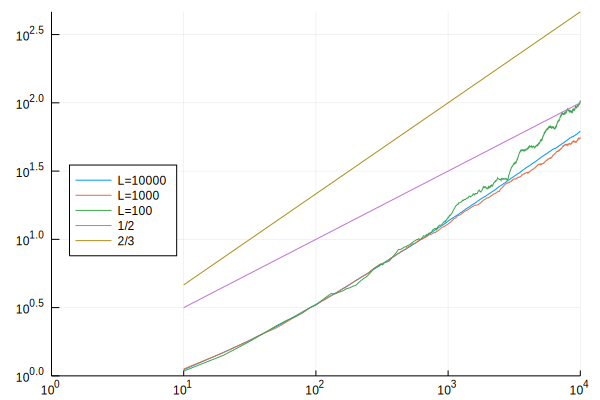

In [16]:
plot(10:10:10000, [roughness10000, roughness1000, roughness100, collect(10:10:10000).^(1/2),collect(10:10:10000).^(2/3)], 
    xaxis=(:log10, (1,Inf)), yaxis=(:log10, (1,Inf)), label=["L=10000","L=1000","L=100","1/2","2/3"], legend=:left)

## Benchmarking

In [41]:
using BenchmarkTools

In [42]:
initial = init_config_multispin(1000, 50)
@benchmark _, _ = runsim(1000,initial)

BenchmarkTools.Trial: 
  memory estimate:  3.21 GiB
  allocs estimate:  25936
  --------------
  minimum time:     1.634 s (22.35% GC)
  median time:      1.733 s (26.59% GC)
  mean time:        1.702 s (25.31% GC)
  maximum time:     1.739 s (26.80% GC)
  --------------
  samples:          3
  evals/sample:     1

## Longer runs

In [103]:
@everywhere using HDF5, JLD

Create a data file

In [119]:
jldopen("FAfront.jld", "w") do file
end

In [160]:
function run_and_save(;L::Int64=1000, H::Int64=100, T::Int64=1000)

    ncores = length(workers())
    
    sum_over_cores = @parallel (+) for i=1:ncores
        initial = init_config_multispin(L, H)
        roughness, config = runsim(T, initial);
        [roughness, front_interior(config)]
    end

    sum_over_cores = sum_over_cores / ncores;

    jldopen("FAfront.jld", "r+") do file
        param_string = "T=$T,L=$L,H=$H,cores=$ncores"
        if !exists(file, param_string)
            params = g_create(file, param_string) # create a group if it doesn't exist
        else
            params = file[param_string]
        end
        this_sim = g_create(params, "$(now())")
        this_sim["roughness"], this_sim["front"] = sum_over_cores;
    end
    
end

run_and_save (generic function with 1 method)

In [181]:
run_and_save(L=10000, H=200, T=100000);

	From worker 13:	Step: 10000
	From worker 7:	Step: 10000
	From worker 5:	Step: 10000
	From worker 17:	Step: 10000
	From worker 3:	Step: 10000
	From worker 4:	Step: 10000
	From worker 2:	Step: 10000
	From worker 8:	Step: 10000
	From worker 15:	Step: 10000
	From worker 6:	Step: 10000
	From worker 14:	Step: 10000
	From worker 9:	Step: 10000
	From worker 10:	Step: 10000
	From worker 12:	Step: 10000
	From worker 11:	Step: 10000
	From worker 16:	Step: 10000
	From worker 13:	Step: 20000
	From worker 7:	Step: 20000
	From worker 4:	Step: 20000
	From worker 15:	Step: 20000
	From worker 17:	Step: 20000
	From worker 2:	Step: 20000
	From worker 3:	Step: 20000
	From worker 5:	Step: 20000
	From worker 12:	Step: 20000
	From worker 6:	Step: 20000
	From worker 8:	Step: 20000
	From worker 14:	Step: 20000
	From worker 10:	Step: 20000
	From worker 9:	Step: 20000
	From worker 11:	Step: 20000
	From worker 16:	Step: 20000
	From worker 7:	Step: 30000
	From worker 13:	Step: 30000
	From worker 15:	Step: 30000
	F